# **Installation, packages, and AWS credential**

In [ ]:
%pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import boto3

In [ ]:
import numpy as np
import pandas as pd
import json
import time
import re
import csv
result = {}
import os
import cv2

In [ ]:
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''
os.environ['AWS_DEFAULT_REGION'] = ''

textract_client = boto3.client('textract')

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

In [ ]:
%%bash
pip install pillow==9.5
pip install layoutparser torchvision && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' --target$nb_path jdc # install detectron2
pip install layoutparser torchvision	--target=$nb_path jdc # install torchvision
pip install layoutparser --target=$nb_path jdc # Install the base layoutparser library
pip install "layoutparser[effdet]"	--target=$nb_path jdc
pip install "layoutparser[ocr]" --target=$nb_path jdc # Install OCR toolkit
#sudo apt install tesseract-ocr --target=$nb_path jdc # install tesseract OCR tool
#pip install pytesseract --target=$nb_path jdc



In [ ]:
import layoutparser as lp
import detectron2

ModuleNotFoundError: ignored

# **Import PDF**

In [ ]:
%%bash
sudo apt-get install poppler-utils --target=$nb_path jdc
pip install pdf2image --target=$nb_path jdc
sudo apt-get install poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (22.02.0-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


E: Command line option --target= is not understood in combination with the other options


In [ ]:
%%bash
sudo apt-get update
sudo apt-get install tesseract-ocr
pip install pytesseract


In [ ]:
# PDF to image
from google.colab.patches import cv2_imshow
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

from pdf2image import convert_from_path
images = convert_from_path(filename)

# Save each page as an image
for i, im in enumerate(images):
    im.save(f"output_page_{i+1}.jpg", "JPEG")

import io
buffered = io.BytesIO()
im.save(buffered, format='PNG')

Saving uc1-c2583271-401-1690535372.pdf to uc1-c2583271-401-1690535372.pdf


In [ ]:
im1=im.save("output.jpg", "JPEG")

im1 = cv2.imread("output.jpg")
im1 = im1[..., ::-1]
cv2_imshow(im1)

NameError: ignored

# **Import image**

In [ ]:
#from pdf2image import convert_from_path
from google.colab.patches import cv2_imshow
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving uc1.c2583271-seq_401.jpg to uc1.c2583271-seq_401.jpg


In [ ]:
image_filename = next(iter(uploaded))
image_path = './' + image_filename

# Save the uploaded image as JPEG
from PIL import Image
im = Image.open(image_path)
#im.save('uploaded_image.jpg')
import io
buffered = io.BytesIO()
im.save(buffered, format='PNG')

In [ ]:
#uploaded = files.upload()
#im = Image.open('uc1.c2583271-seq_399.jpg')

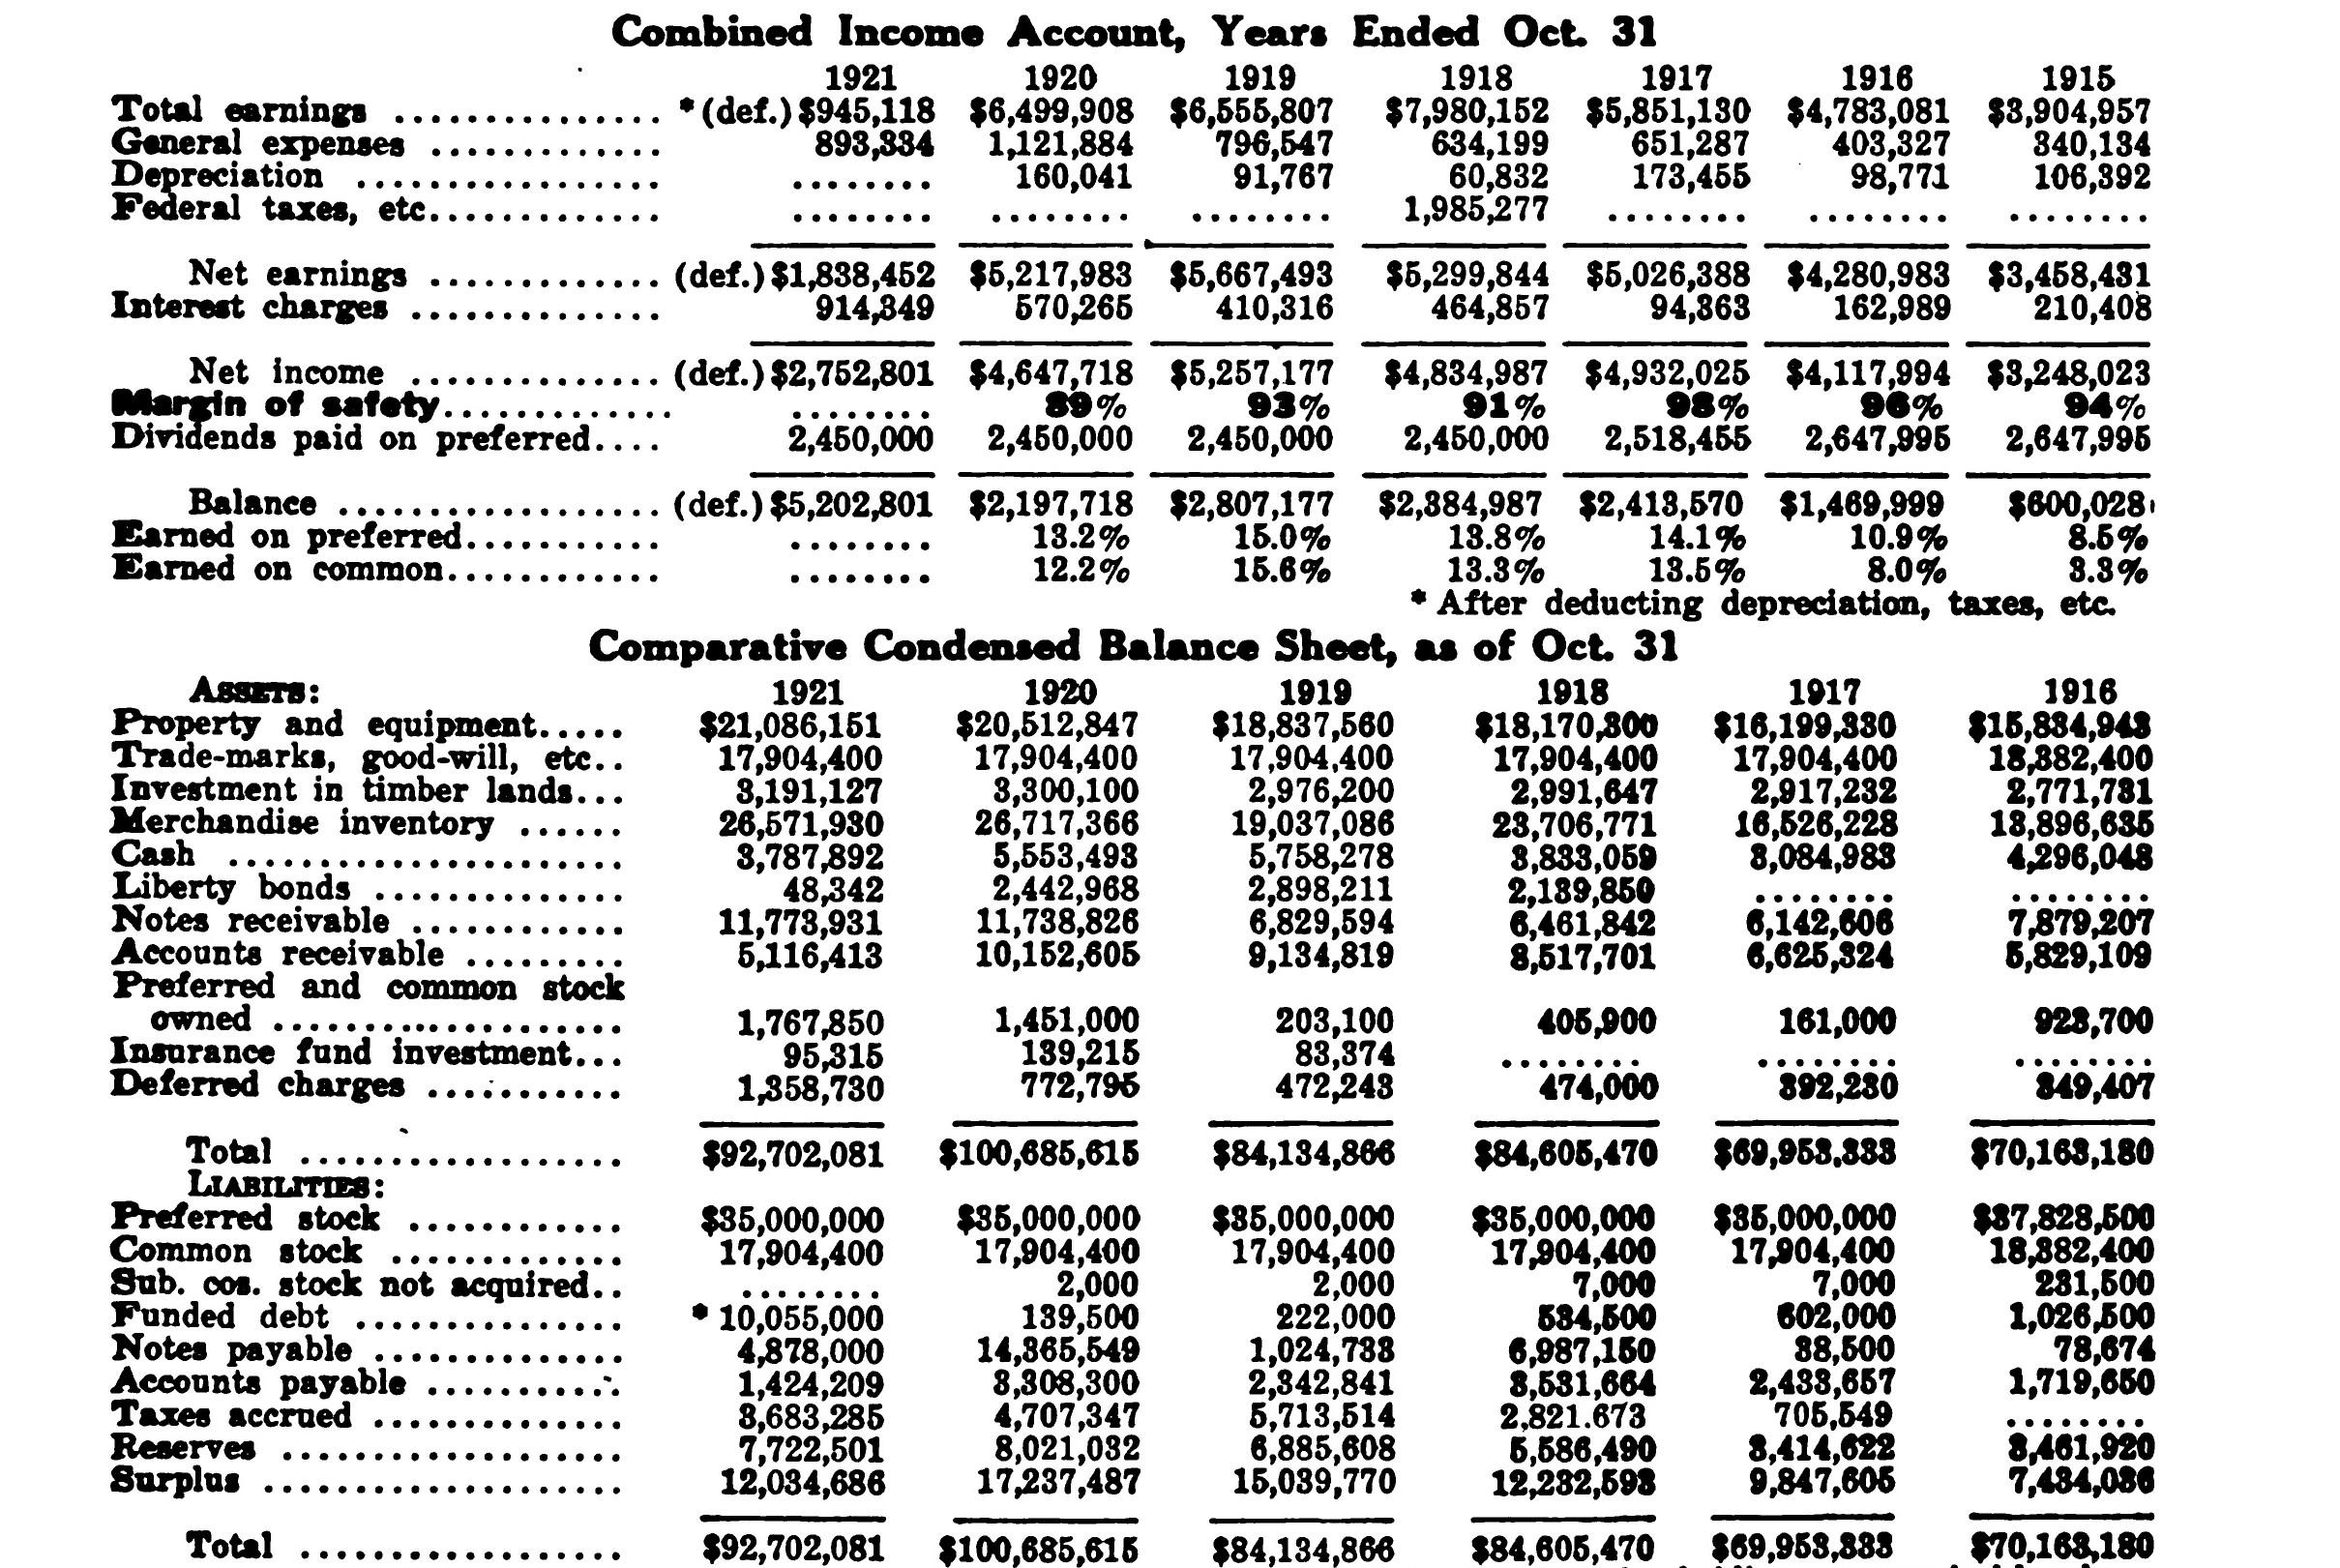

In [ ]:
im1= Image.open(image_path)
im1.save("output.jpg", "JPEG")

im1 = cv2.imread("output.jpg")
im1 = im1[..., ::-1]
cv2_imshow(im1)

# **Textract: table**

- Sometimes textract does not identify all tables in a page. 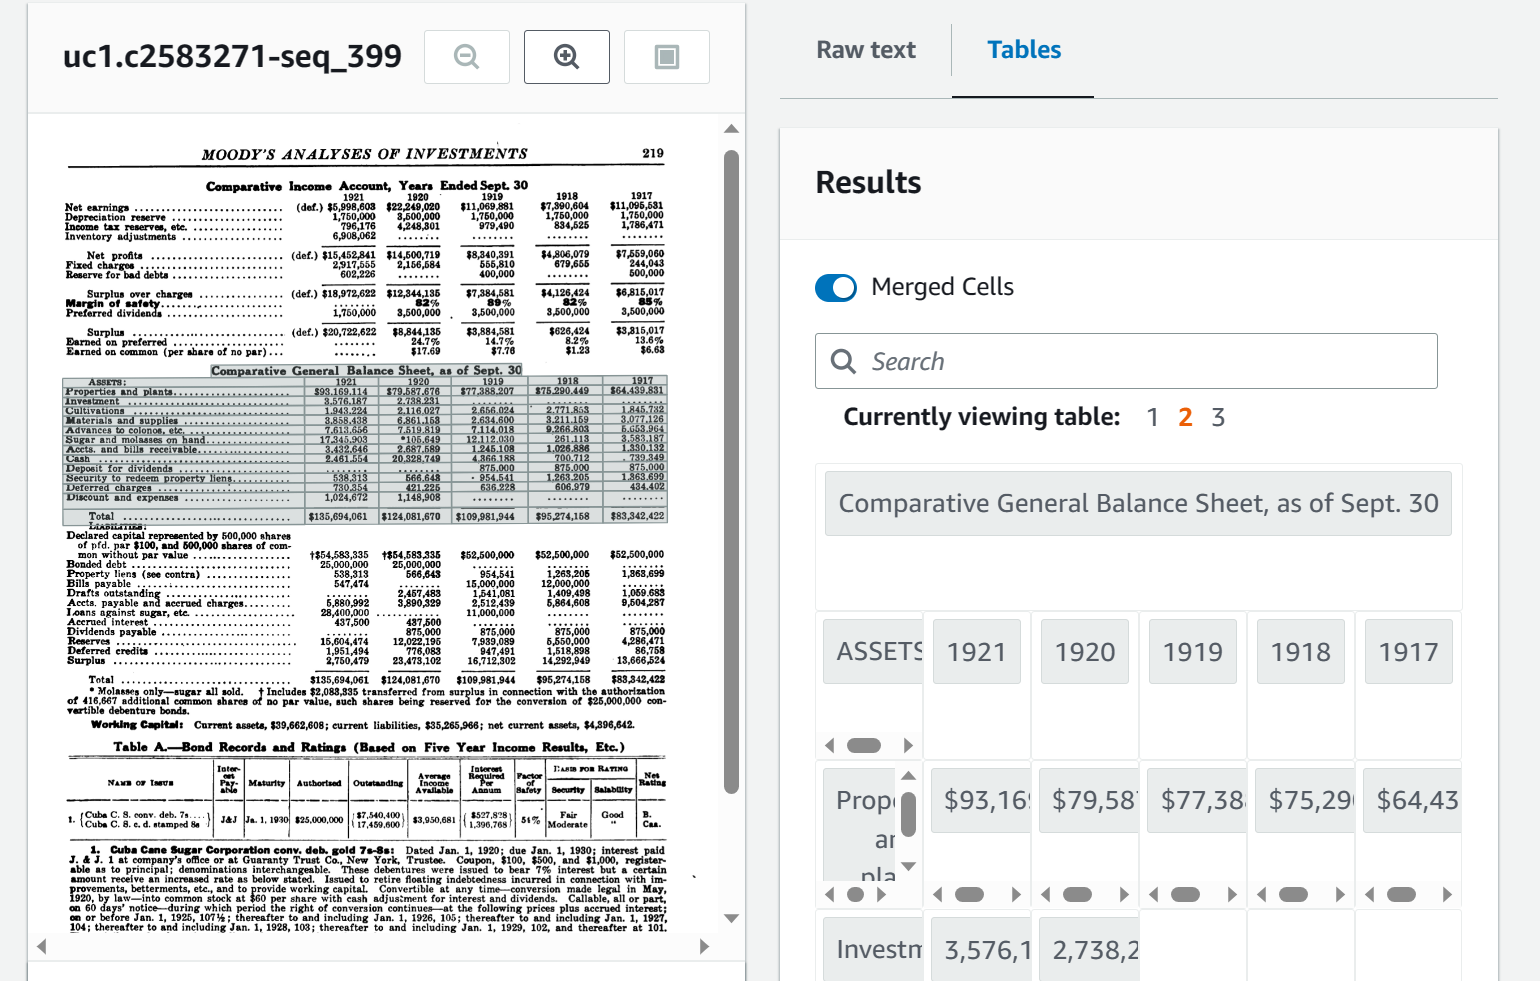

- In the screenshot above, there are four tables in the page, but textract only extract three of them (the third one is omitted).

In [ ]:
# call textract
client = boto3.client('textract')
response = client.analyze_document(
    Document={'Bytes': buffered.getvalue()},
    FeatureTypes=['TABLES']
)

In [ ]:
# functions for extracting and printing tables in Python
def map_blocks(blocks, block_type):
    return {
        block['Id']: block
        for block in blocks
        if block['BlockType'] == block_type
    }

blocks = response['Blocks']
tables = map_blocks(blocks, 'TABLE')
cells = map_blocks(blocks, 'CELL')
words = map_blocks(blocks, 'WORD')
selections = map_blocks(blocks, 'SELECTION_ELEMENT')

In [ ]:
def get_children_ids(block):
    for rels in block.get('Relationships', []):
        if rels['Type'] == 'CHILD':
            yield from rels['Ids']

In [ ]:
import pandas as pd

dataframes = []

for table in tables.values():

    # Determine all the cells that belong to this table
    table_cells = [cells[cell_id] for cell_id in get_children_ids(table)]

    # Determine the table's number of rows and columns
    n_rows = max(cell['RowIndex'] for cell in table_cells)
    n_cols = max(cell['ColumnIndex'] for cell in table_cells)
    content = [[None for _ in range(n_cols)] for _ in range(n_rows)]

    # Fill in each cell
    for cell in table_cells:
        cell_contents = [
            words[child_id]['Text']
            if child_id in words
            else selections[child_id]['SelectionStatus']
            for child_id in get_children_ids(cell)
        ]
        i = cell['RowIndex'] - 1
        j = cell['ColumnIndex'] - 1
        content[i][j] = ' '.join(cell_contents)

    # We assume that the first row corresponds to the column names
    dataframe = pd.DataFrame(content[1:], columns=content[0])
    dataframes.append(dataframe)

In [ ]:
# number of tables detected
len(dataframes)

2

In [ ]:
dataframes[0]

,,1921,1920,1919,1918,1917,1916,1915
0,Total earnings,"(def.) $945,118","$6,499,908","$6,555,807","$7,980,152","$5,851,130","$4,783,081","$3,904,957"
1,General expenses,"893,334","1,121,884","796,547","634,199","651,287","403,327","340,134"
2,Depreciation,,"160,041","91,767","60,832","173,455","98,771","106,392"
3,"Federal taxes, etc",,,,"1,985,277",,,
4,Net earnings,"(def.) $1,838,452","$5,217,983","$5,667,493","$5,299,844","$5,026,388","$4,280,983","$3,458,431"
5,Interest charges,"914,349","570,265","410,316","464,857","94,363","162,989","210,408"
6,Net income,"(def.) $2,752,801","$4,647,718","$5,257,177","$4,834,987","$4,932,025","$4,117,994","$3,248,023"
7,Margin of safety,,89%,93%,91%,98%,96%,94%
8,Dividends paid on preferred,"2,450,000","2,450,000","2,450,000","2,450,000","2,518,455","2,647,995","2,647,995"
9,Balance,"(def.) $5,202,801","$2,197,718","$2,807,177","$2,384,987","$2,413,570","$1,469,999","$600,028"


In [ ]:
dataframes[1]

,ASSETS:,1921,1920,1919,1918,1917,1916
0,Property and equipment,"$21,086,151","$20,512,847","$18,837,560","$18,170,300","$16,199,330","$15,834,943"
1,"Trade-marks, good-will, etc","17,904,400","17,904,400","17,904,400","17,904,400","17,904,400","18,382,400"
2,Investment in timber lands,"3,191,127","3,300,100","2,976,200","2,991,647","2,917,232","2,771,731"
3,Merchandise inventory,"26,571,930","26,717,366","19,037,086","23,706,771","16,526,228","18,896,635"
4,Cash,"3,787,892","5,553,493","5,758,278","3,833,059","8,084,983","4,296,048"
5,Liberty bonds,"48,342","2,442,968","2,898,211","2,139,850",,
6,Notes receivable,"11,773,931","11,738,826","6,829,594","6,461,842","6,142,606","7,879,207"
7,Accounts receivable,"5,116,413","10,152,605","9,134,819","8,517,701","6,625,324","5,829,109"
8,Preferred and common stock owned,"1,767,850","1,451,000","203,100","405,900","161,000","923,700"
9,Insurance fund investment,"95,315","139,215","83,374",,,


In [ ]:
dataframes[2]

,Num,,Course Title,Mk,Code,Cred
0,Henry M.,Gunn,High Grd 11 21-22,Term,1,
1,2459,,AP Calculus BC,A,,5.00
2,3609,,AP Chemistry,A,,5.00
3,3824,,AP Physics 1,A,,5.00
4,4449,,AP Spanish Langua,A+,,5.00
5,1699,,AP US History,A-,,5.00
6,8484AS,,Gen Weep11,A,,5.00
7,6455,,Wind Ens,A,,5.00
8,7662,,World Classics H,A,,5.00
9,,,GPA: 4.000,,,40.00


In [ ]:
dataframes[3]

,Work Num,In Progress Course Title,,Cred
0,Econ 1811,Econ AP,,5.0
1,English 1279,AP English Lit & Comp,,5.0
2,Fine Arts,,,
3,6455,Wind Ens,,"5,0"
4,Living,Skills,,
5,8458,Liv Skill,,5.0
6,Math,,,
7,2319,AP Statistics,,5.0
8,Phys Sci 3859E S St,AP Physics C: E&M,,5.0
9,1859,AP Psychology,,5.0


# **Textract: Raw text mixed with textual table**

In [ ]:
# retrieve the path of the imported image
image_path = list(uploaded.keys())[0]
full_path = os.path.abspath(image_path)
full_path

'/content/uc1.c2583271-seq_399.jpg'

In [ ]:
with open(full_path, 'rb') as document:
    img = bytearray(document.read())

# Call Amazon Textract
response = client.detect_document_text(
    Document={'Bytes': img}
)

In [ ]:
# print text
def extract_text_from_response(response):
    extracted_text = ""

    for block in response["Blocks"]:
        if block["BlockType"] == "LINE":
            extracted_text += block["Text"] + "\n"

    return extracted_text

text = extract_text_from_response(response)

print(text)

# **JSON values and ChatGPT**

- Here we are trying to import table into ChatGPT as the the prompt. Since ChatGPT cannot process dataframes, we have two options: to convert the table to JSON values or csv text.
- Currently, JSON value is more efficient and accurate for ChatGPT to read. However, the dataframes that textract generated sometimes have not unique columns, which is instead required to convert a dataframes into dic. (see errors below)
- On the other hand, CSV text may ignore (def) or other notations

In [ ]:
# csv text
csv_text = dataframes[0].to_csv(index=False)
csv_text

',1921,1920,1919,1918,1917,1916,1915\nTotal earnings,"(def.) $945,118","$6,499,908","$6,555,807","$7,980,152","$5,851,130","$4,783,081","$3,904,957"\nGeneral expenses,"893,334","1,121,884","796,547","634,199","651,287","403,327","340,134"\nDepreciation,,"160,041","91,767","60,832","173,455","98,771","106,392"\n"Federal taxes, etc",,,,"1,985,277",,,\nNet earnings,"(def.) $1,838,452","$5,217,983","$5,667,493","$5,299,844","$5,026,388","$4,280,983","$3,458,431"\nInterest charges,"914,349","570,265","410,316","464,857","94,363","162,989","210,408"\nNet income,"(def.) $2,752,801","$4,647,718","$5,257,177","$4,834,987","$4,932,025","$4,117,994","$3,248,023"\nMargin of safety,,89%,93%,91%,98%,96%,94%\nDividends paid on preferred,"2,450,000","2,450,000","2,450,000","2,450,000","2,518,455","2,647,995","2,647,995"\nBalance,"(def.) $5,202,801","$2,197,718","$2,807,177","$2,384,987","$2,413,570","$1,469,999","$600,028"\nEarned on preferred,,13.2%,15.0%,13.8%,14.1%,10.9%,8.5%\nEarned on common,,12.

In [ ]:
# JSON values
json_data= dataframes[1].to_json()
print(json_data)

{"Num":{"0":"Henry M.","1":"2416","2":"7010","3":"3131","4":"1181","5":"2791","6":"4420","7":"1625","8":"","9":"Henry M.","10":"2416","11":"7010","12":"3131","13":"2792","14":"4420","15":"0118","16":"1625","17":"","18":"Henry M.","19":"2399","20":"3625","21":"1191","22":"8429AS","23":"2696","24":"4430","25":"7013","26":"1753","27":"","28":"Henry M.","29":"2399","30":"3625","31":"1641","32":"8429AS","33":"1193","34":"2696","35":"4430","36":"7013","37":""},"Course Title":{"0":"Gunn High Grd 09 19-20","1":"Alg2\/TrigH","2":"Band","3":"Biology H","4":"Communic A","5":"PE 9\/11","6":"Spanish 2","7":"Wld Hist","8":"GPA: 3.857","9":"Gunn High Grd 09 19-20","10":"Alg2\/TrigH","11":"Band","12":"Biology H","13":"PE 9\/12","14":"Spanish 2","15":"Western Culture A","16":"WId Hist","17":"GPA: (did not calculate)","18":"Gunn High Grd 10 20-21","19":"Analysis H","20":"Chemistry H","21":"Cont Herit","22":"ExplExp-AAR","23":"PE 10","24":"Spanish 3","25":"Symph Band","26":"US Govt","27":"GPA: 4.000","28

In [ ]:
# alternative
data_dict = dataframes[1].to_dict(orient='records')
json_data = json.dumps(data_dict)
print(json_data)

In [ ]:
# OpenAI credential
%pip install openai
%pip install PyPDF2
import openai
openai.api_key = "" # input api key here
models = openai.Model.list()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
# import csv text to ChatGPT
input = csv_text + f'. This table is in csv text. Convert this into a readable table. mark all empty cell as 0 and replace (def) or (d) with negative sign. Eliminate dollar sign and convert all entry to numberic values. Convert this table to JSON values with the year as the key. '
completion=openai.ChatCompletion.create(model="gpt-3.5-turbo",messages=[{"role": "user", "content": input}])
output_csv = completion["choices"][0]["message"]["content"]
print(output_csv)

{
  "1926": {
    "ASSETS": {
      "Comparative, Consolidated, Balance Sheet, as, of Dec. 31, 1926": 0
    },
    "Plants, etc.": 211972889,
    "Woodlands": 34029768,
    "Securities": 39474650,
    "Gatineau Pr. bonds": 0,
    "Gatineau Pr. cash in escrow": 0,
    "Due from affiliated companies Cash": 8044219,
    "Accounts receivable": 11967463,
    "Notes receivable": 1404126,
    "Inventories, etc.": 37462018,
    "Sinking fund": 58313,
    "Prepaid and deferred expense.": 4829048,
    "Bond discount": 4978645,
    "Total LIABILITIES": 358931181,
    "Preferred stock": 1828000,
    "Preferred stock. 7%": 96105600,
    "Can. Hy.-El. Corp. preferred": 0,
    "Subsidiary stock": 431205,
    "Common stock": 52500000,
    "Common stock. subscription": 0,
    "Gatineau El. St., minority int": 0,
    "Funded debt": 69891429,
    "Bank loans": 0,
    "Notes payable": 19280000,
    "Accounts payable": 5845716,
    "Accrued interest": 0,
    "Dividends payable": -1690437,
    "Due affiliat

In [ ]:
# import json values to ChatGPT
input = json_data + f'. This is in JSON value. Convert this into a readable table. mark all empty cell as 0 and replace (def) with negative sign '
completion=openai.ChatCompletion.create(model="gpt-3.5-turbo",messages=[{"role": "user", "content": input}])
output_json = completion["choices"][0]["message"]["content"]
print(output_json)

In [ ]:
# Select variables and remove notations. Export table in JSON values
input = output_json + f'. Eliminate dollar sign and convert all entry to numberic values. Select only total, surplus, funded debt, preferred stock and common stock variables. Convert this table to JSON values with the year as the key. '
completion=openai.ChatCompletion.create(model="gpt-3.5-turbo",messages=[{"role": "user", "content": input}])
output1 = completion["choices"][0]["message"]["content"]
print(output1)

{
  "1921": {
    "Total earnings": 945118,
    "Net earnings": 1838452,
    "Net income": 2752801,
    "Balance": 5202801,
    "Earned on preferred": 0,
    "Earned on common": 0
  },
  "1920": {
    "Total earnings": 6499908,
    "Net earnings": 5217983,
    "Net income": 4647718,
    "Balance": 2197718,
    "Earned on preferred": 13.2,
    "Earned on common": 12.2
  },
  "1919": {
    "Total earnings": 6555807,
    "Net earnings": 5667493,
    "Net income": 5257177,
    "Balance": 2807177,
    "Earned on preferred": 15.0,
    "Earned on common": 15.6
  },
  "1918": {
    "Total earnings": 7980152,
    "Net earnings": 5299844,
    "Net income": 4834987,
    "Balance": 2384987,
    "Earned on preferred": 13.8,
    "Earned on common": 13.3
  },
  "1917": {
    "Total earnings": 5851130,
    "Net earnings": 5026388,
    "Net income": 4932025,
    "Balance": 2413570,
    "Earned on preferred": 14.1,
    "Earned on common": 13.5
  },
  "1916": {
    "Total earnings": 4783081,
    "Net ear

In [ ]:
output_csv.replace('\n','').replace(' ','')
json_string = output_csv

# Convert the JSON string to a Python dictionary using json.loads()
data_dict = json.loads(json_string)
table_output=pd.DataFrame(data_dict)
table_output

,1926,1925,1928,1927
ASSETS,"{'Comparative, Consolidated, Balance Sheet, as...","{'Comparative, Consolidated, Balance Sheet, as...","{'Comparative, Consolidated, Balance Sheet, as...","{'Comparative, Consolidated, Balance Sheet, as..."
"Plants, etc.",211972889,195792590,239833746,160755003
Woodlands,34029768,34704944,36687607,26906797
Securities,39474650,40949343,32616483,40582237
Gatineau Pr. bonds,0,0,1912346,8871313
Gatineau Pr. cash in escrow,0,0,0,0
Due from affiliated companies Cash,8044219,4710042,6982794,5738675
Accounts receivable,11967463,11760596,12824448,8434766
Notes receivable,1404126,1968718,907015,549900
"Inventories, etc.",37462018,32223392,38265942,27687498


In [ ]:
table_output.to_excel('output.xlsx', index=False)